## Construire une représentation pour des images :
Idée : Ici on va s'appuyer sur l'article (a simple Framework for Contrastive Learning of Visual Representations)
Pour construire une bonne representation d'images :

On s'entraîne sur un jeu d'uimages chat/chiens, l'idée serait de construire une reprsentation des images de chats et de chiens
Puis de faire une ACP ou tsbne sur les données en sortie en ligne chat ou chien en colonne la représentation et voir si l'espace sépare bien les chats et les chiens

Idée de l'entraînement de l'algorithme :

On définit 2 réseaux, un convolutif et un "normaliseur", f et g (paramètres mouvants) ( g un simple bi couche avec une relu au milieu) ( et f un resnet pretrained ?)

Pour une image donnée  on crée 2 images transformées x1 et x2 (rotation découpage etc..)
On calcule out1 = f(g(x1)) et out2 = f(g(x2)) et on voudrait que ces 2 quantités soient proches.

Pour calculer la proximité on utilise la cosine similarity entre les 2 outputs out1 et out2 (cos(a,b) divisé par les 2 normes)
Pour evaluer la proximité on la compare dans une statistique à la similarité de out1 et out2 à la similarité de out1 avec d'autres images tirées aléatoirement

En gros l'algo est le suivant pour un batch :

1) Tirer  N images 
2) Appliquer les transformation aléatoires t et t' à ces images  =>  x11..xN1 et x12..xN2
3) calculer les l(xi1,xi2) pour i allant de 1 à N et les l(xi2,xi1) car  => losse global
4) => backward :)

Je fais ça avec les images d'oiseau pour pas m'embêter

In [4]:
!pip install -q -q -q tqdm 
#!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install -q -q -q pandas
!pip install -q -q -q imageio
!pip install -q -q -q scikit-learn

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.3 MB/s eta 0:00:00:00:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 16.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 24.2 MB/s eta 0:00:00a 0:00:01


In [47]:
%load_ext autoreload
%autoreload 2

import os
import s3fs
import shutil
import torch
from pathlib import Path
import random
import imageio.v3 as iio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
if torch.cuda.is_available() : device= torch.device("cuda:0" ) 
else : device  = "cpu"
print("Using {} device".format(device))
if device != "cpu" :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

Using cpu device


In [7]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-funathon/diffusion/Sujet9_deep_learning_donnees_satellites/archive.zip', 'oiseau.zip')
shutil.unpack_archive('oiseau.zip')

In [8]:
bird_df = pd.read_csv('birds.csv')
NB_CLASSES = 2
#On se limite à 20 classes
bird_df = bird_df[bird_df['class index'] < NB_CLASSES]

train_images_paths = np.array(bird_df['filepaths'])
train_images_labels = np.array(bird_df['class index'])

# index to nom d'oiseau
nom_oiseau = np.array(bird_df.labels.unique())
dic_id_to_label = {i : oiseau for i,oiseau in zip(range(NB_CLASSES),nom_oiseau)}
dic_id_to_label

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY'}

Dans la classe custom Dataset je mets en place la transformation aléatoire et je sors 2 images transformées :
le papier préconise l'application successive de :
1) random cropping
2) random color distortion
3) random Gaussian blur


In [60]:
class CustomDataset(Dataset):
    def __init__(self, image_paths,labels): 
        self.image_paths = image_paths
        self.labels = labels
        
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = iio.imread(self.image_paths[idx]) 
        image = torch.tensor(np.array(image,dtype = float)/255, dtype =torch.float).permute(2,1,0)     
         
        TF = transforms.Compose([
        transforms.RandomResizedCrop(size=(224,224),scale= (0.08,1),ratio= (3/4,4/3)),
        transforms.ColorJitter(brightness = 0.8,
                       contrast = (0.2,0.8),
                       saturation = (0.2,0.8), 
                       hue =0.2),
        transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
        ])    
        
        image1 = TF(image)
        image2 = TF(image)
        
        label = self.labels[idx]
        
        return {"tf1": image1, "tf2" : image2, "label" : label} 
        
        
    def __len__(self):  # return count of sample we have
        return len(self.image_paths)
    

In [9]:
 def montrer_image(image):
    img = image.permute(2,1,0)
    img = np.array(img)
    plt.imshow(np.array(img))
    plt.show()

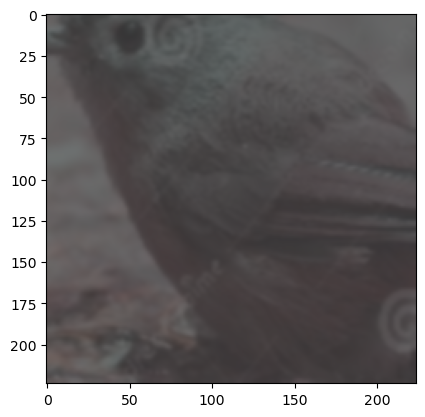

0


In [66]:
all_dataset = CustomDataset(train_images_paths,train_images_labels)

it = iter(all_dataset)
data = next(it)
montrer_image(data["tf1"])
print(data["label"])

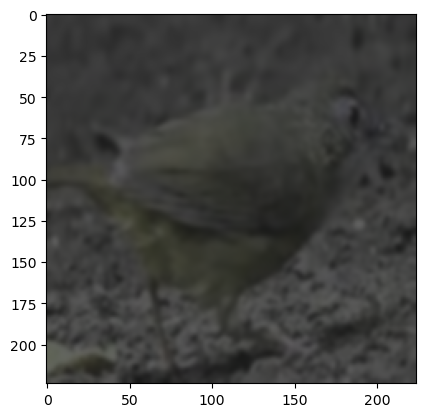

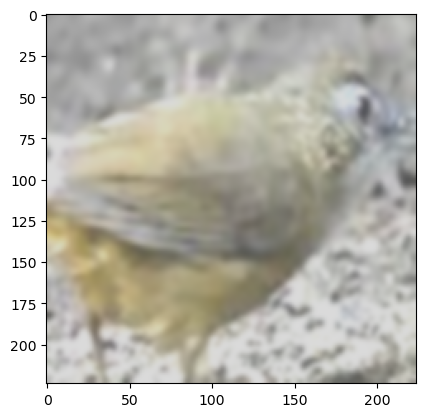

In [145]:
config = {"batch_size" :32,
         "lr" : 0.0002,
         "n_epoch" : 100}
data_loader = DataLoader(all_dataset, batch_size=config["batch_size"],shuffle=True, num_workers=0)

batch = next(iter(data_loader))
montrer_image(batch["tf1"][0])
montrer_image(batch["tf2"][0])

Je télécharge le resnet pretrained pour créer la rerprésentation puis je créerai le projecteur de toute pièce.

In [147]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True) # réseau pretrained

class projectionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1000, 400)
        self.fc2 = nn.Linear(400, 50)
        
    def forward(self, x):
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class SimCLR(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = projectionNetwork()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True) # réseau pretrained
        
    def forward(self, x):
        #print(x.size())
        x = self.resnet(x)
        x = self.proj(x)
        return x


Using cache found in /home/onyxia/.cache/torch/hub/pytorch_vision_v0.10.0


### Training !!! 
Topute la finesse encore une fois se trouve dans la constructiond e la loss il faut faire en sorte de garder le gradient..

In [ ]:


if torch.cuda.is_available() : device= torch.device("cuda:0" ) 

net = SimCLR()
optimizer = optim.Adam(net.parameters(), lr=config['lr'])
net = net.to(device)

liste_loss = []

for epoch in range(config['n_epoch']):  
        
        net = net.to(device)
        running_loss = 0.0

        t= tqdm(data_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
        epoch_loop = enumerate(t)

        for i, batch in epoch_loop:
            
            
            tf1 = batch["tf1"]
            tf2 = batch["tf2"]
            
            tf1, tf2 = tf1.to(device), tf2.to(device)
            
            res_transfo1 = net(tf1)
            res_transfo2 = net(tf2)
            
            cosineMat = torch.mm(res_transfo1/torch.norm(res_transfo1), # cosine similarity pairwise
            torch.transpose(res_transfo2/torch.norm(res_transfo2),0,1)
                                )
            
            # cosineMat.shape 
            # j'ai bien une matrice 32x 32 
            # je ne fais pas exactement la même loss que dans l'article mazis en gros je compare la loss du coefficient diagonale avec les losses sur la même ligne et sur la même colonne

            loss = 0
    
            for ind in range(config["batch_size"]):
                
                rowi = cosineMat[ind,:]
                coli = cosineMat[:,ind]

                sum_row_mi = torch.sum(torch.exp(torch.cat([rowi[:ind], rowi[ind+1:]])))
                loss_row = -torch.log(torch.exp(cosineMat[ind,ind])/sum_row_mi)

                sum_col_mi = torch.sum(torch.exp(torch.cat([coli[:ind], coli[ind+1:]])))
                loss_col = -torch.log(torch.exp(cosineMat[ind,ind])/sum_col_mi)

                loss += (loss_col + loss_row)


            # zero the parameter gradients
            optimizer.zero_grad()

            loss.backward() # calculer le gradient
            optimizer.step() # avancer dans le sens du gradient calculé

            del tf1, tf2, cosineMat
            running_loss += loss.item()

            if (i+1) % 3 == 0:  
                # ici enregistrement de la loss sur le train, sur le validation et envoi des résultats à wnandb
                
                liste_loss.append(running_loss)

                # validation
                t.set_description("epoch %i, 'mean loss: %.6f'" % (epoch+1,running_loss/10))
                t.refresh()
                
                running_loss = 0



Using cache found in /home/onyxia/.cache/torch/hub/pytorch_vision_v0.10.0
epoch 1, 'mean loss: 65.468517':  83%|████████▎ | 10/12 [00:35<00:06,  3.42s/it]

## tsne ACP chat chien 
1) Récupération des représentations pour toutes les images
2) Big ACP/t-sne
3) On observe la répartition des points sur les premiers axes en les colorants par leurs labels 

Sur wandbe mettre l'inertie intra classe dans la TSNE en indicateur par exemple